#Preparing my local drive and libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install segmentation_models

     |████████████████████████████████| 50 kB 4.9 MB/s 


In [3]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,Input,GlobalMaxPooling2D
from tensorflow.keras.models import load_model,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical,custom_object_scope
from tensorflow.keras.metrics import MeanIoU
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


In [4]:
from zipfile import ZipFile
PathofZIP='/content/drive/MyDrive/consep.zip'
ZipFile(PathofZIP).extractall('Dataset')

#Import Images

In [4]:
from PIL import Image
import numpy as np
size=500
X_train=np.zeros((27,size,size,3))
X_test=np.zeros((14,size,size,3))
for i in range(27):
  X_train[i]=np.array(Image.open('/content/Dataset/CoNSeP/Train/Images/train_'+str(i+1)+'.png').resize((size,size)))[:,:,:3]
for i in range(14):
  X_test[i]=np.array(Image.open('/content/Dataset/CoNSeP/Test/Images/test_'+str(i+1)+'.png').resize((size,size)))[:,:,:3]


In [5]:
import scipy.io
Y_train=np.zeros((27,size,size))
Y_test=np.zeros((14,size,size))
for i in range(27):
  a=scipy.io.loadmat('/content/Dataset/CoNSeP/Train/Labels/train_'+str(i+1)+'.mat')['type_map']
  a[a==3]=3
  a[a==4]=3
  a[a>4.]=4
  img=Image.fromarray(a).resize((size,size))
  Y_train[i]=np.array(img)
for i in range(14):
  a=scipy.io.loadmat('/content/Dataset/CoNSeP/Test/Labels/test_'+str(i+1)+'.mat')['type_map']
  a[a==3]=3
  a[a==4]=3
  a[a>4.]=4
  img=Image.fromarray(a).resize((size,size))
  Y_test[i]=np.array(img)

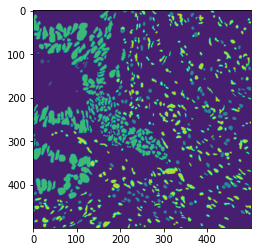

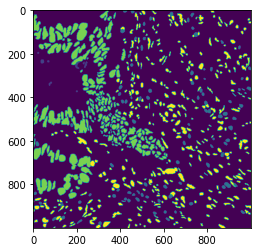

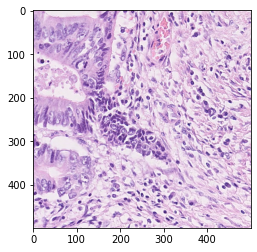

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(Y_train[0])
plt.show()
plt.imshow(scipy.io.loadmat('/content/Dataset/CoNSeP/Train/Labels/train_1.mat')['type_map'])
plt.show()
plt.imshow(X_train[0].astype(np.uint8))
plt.show()

#Data Aumentation

In [31]:
import imgaug as ia
import imgaug.augmenters as iaa

seq = iaa.Sequential([
    iaa.Dropout([0.05, 0.2]),      
    iaa.Sharpen((0.0, 1.0)),       
    iaa.Affine(rotate=(-10, 10)),  
    iaa.ElasticTransformation(alpha=50, sigma=5),
    iaa.Fliplr(0.5),
    iaa.Add((-40, 40)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)) 
], random_order=True)

aug_X=[]
aug_Y=[]
for j in range(3):
  for i in range(len(X_train)):
    X , Y = seq.augment(image=X_train[i].astype(np.uint8),segmentation_maps=Y_train[i].reshape(1,500,500).astype(np.uint8))
    aug_X.append(X)
    aug_Y.append(Y)


aug_X_test=[]
aug_Y_test=[]
for i in range(len(X_test)):
  X , Y = seq.augment(image=X_test[i].astype(np.uint8),segmentation_maps=Y_test[i].reshape(1,500,500).astype(np.uint8))
  aug_X_test.append(X)
  aug_Y_test.append(Y)

In [32]:
aug_X=np.array(aug_X)
aug_Y=np.array(aug_Y).reshape(-1,500,500)
aug_X_test=np.array(aug_X_test)
aug_Y_test=np.array(aug_Y_test).reshape(-1,500,500)
print(aug_X.shape)
print(aug_Y.shape)

(81, 500, 500, 3)
(81, 500, 500)


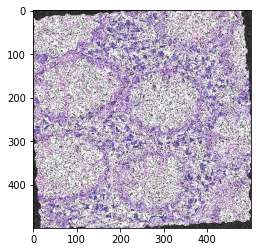

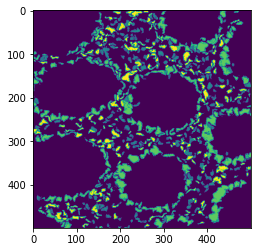

In [33]:
plt.imshow(aug_X[5])
plt.show()
plt.imshow(aug_Y[5])
plt.show()

In [34]:
X_train=np.concatenate((X_train,aug_X),axis=0)
Y_train=np.concatenate((Y_train,aug_Y),axis=0)
X_test=np.concatenate((X_test,aug_X_test),axis=0)
Y_test=np.concatenate((Y_test,aug_Y_test),axis=0)

Shuffling New Dataset

In [35]:
def shuffling(x,y):
  index=list(range(len(x)))
  np.random.shuffle(index)
  x_new=x[index]
  y_new=y[index]
  return x_new , y_new

In [36]:
X_train,Y_train =shuffling(X_train,Y_train)
X_test ,Y_test =shuffling(X_test,Y_test)

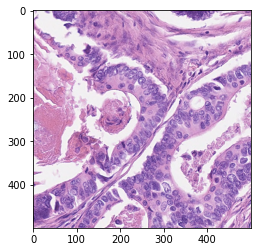

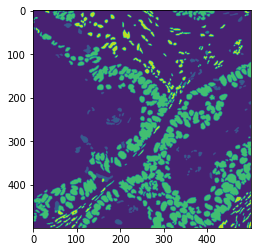

In [37]:
plt.imshow(X_train[15].astype(np.uint8))
plt.show()
plt.imshow(Y_train[15])
plt.show()

#Preproccesing

One Hot

In [7]:
Y_train=to_categorical(Y_train)
Y_test=to_categorical(Y_test)
Y_train.shape

(27, 500, 500, 5)

/255

In [ ]:
X_train=X_train/255
X_test=X_test/255

#With Unet Model From https://www.kaggle.com/basu369victor/transferlearning-and-unet-to-segment-rocks-on-moon

Load the pretrained model from rocks on moon project

In [39]:
unet_model=load_model('/content/drive/MyDrive/model_TL_UNET.h5')
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 500, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 500, 500, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 500, 500, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 250, 250, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

add a classifier layer to the end of the model

In [40]:
inp = Input(shape=(500, 500, 3))
x = unet_model(inp)
x = Conv2D(5, (3,3), padding='same', activation='softmax')(x)
full_model = Model(inputs=[inp], outputs=[x])

Training the last layer (classifier) of the full model

In [41]:
unet_model.trainable=False
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
model_1 (Functional)         (None, 500, 500, 3)       31947599  
_________________________________________________________________
conv2d (Conv2D)              (None, 500, 500, 5)       140       
Total params: 31,947,739
Trainable params: 140
Non-trainable params: 31,947,599
_________________________________________________________________


In [42]:
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',MeanIoU(num_classes=5)])

In [43]:
history=full_model.fit(X_train,Y_train,epochs=10,batch_size=3)

Epoch 1/10
36/36 [==============================] - 81s 1s/step - loss: 4.1215 - acc: 0.1543 - mean_io_u: 0.4000
Epoch 2/10
36/36 [==============================] - 37s 1s/step - loss: 1.0198 - acc: 0.7241 - mean_io_u: 0.4000
Epoch 3/10
36/36 [==============================] - 37s 1s/step - loss: 0.9139 - acc: 0.7811 - mean_io_u: 0.4000
Epoch 4/10
36/36 [==============================] - 37s 1s/step - loss: 0.9059 - acc: 0.7858 - mean_io_u: 0.4000
Epoch 5/10
36/36 [==============================] - 37s 1s/step - loss: 0.8999 - acc: 0.7856 - mean_io_u: 0.4000
Epoch 6/10
36/36 [==============================] - 37s 1s/step - loss: 0.8908 - acc: 0.7878 - mean_io_u: 0.4000
Epoch 7/10
36/36 [==============================] - 37s 1s/step - loss: 0.8846 - acc: 0.7874 - mean_io_u: 0.4000
Epoch 8/10
36/36 [==============================] - 37s 1s/step - loss: 0.8815 - acc: 0.7898 - mean_io_u: 0.4000
Epoch 9/10
36/36 [==============================] - 38s 1s/step - loss: 0.8737 - acc: 0.7912 - m

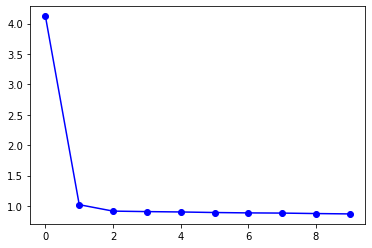

In [44]:
plt.plot(history.history['loss'], 'b-o')

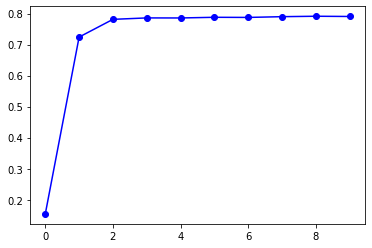

In [45]:
plt.plot(history.history['acc'], 'b-o')

Fine_tuning the full model

In [46]:
unet_model.trainable=True
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',iou_score,MeanIoU(num_classes=5)])

In [47]:
history=full_model.fit(X_train,Y_train,epochs=30,batch_size=3)

Epoch 1/30
36/36 [==============================] - 111s 3s/step - loss: 1.3534 - acc: 0.6309 - iou_score: 0.0991 - mean_io_u_1: 0.4000
Epoch 2/30
36/36 [==============================] - 96s 3s/step - loss: 1.1353 - acc: 0.7637 - iou_score: 0.1267 - mean_io_u_1: 0.4000
Epoch 3/30
36/36 [==============================] - 96s 3s/step - loss: 0.9494 - acc: 0.8059 - iou_score: 0.1498 - mean_io_u_1: 0.4000
Epoch 4/30
36/36 [==============================] - 96s 3s/step - loss: 0.8431 - acc: 0.8141 - iou_score: 0.1684 - mean_io_u_1: 0.4000
Epoch 5/30
36/36 [==============================] - 96s 3s/step - loss: 0.7494 - acc: 0.8314 - iou_score: 0.1763 - mean_io_u_1: 0.4000
Epoch 6/30
36/36 [==============================] - 96s 3s/step - loss: 0.6411 - acc: 0.8419 - iou_score: 0.1925 - mean_io_u_1: 0.4000
Epoch 7/30
36/36 [==============================] - 94s 3s/step - loss: 0.5910 - acc: 0.8449 - iou_score: 0.2004 - mean_io_u_1: 0.4000
Epoch 8/30
36/36 [==============================] - 94

In [13]:
plt.plot(history.history['loss'], 'b-o')

NameError: ignored

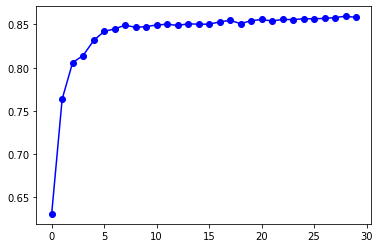

In [49]:
plt.plot(history.history['acc'], 'b-o')

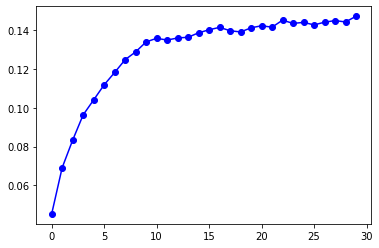

In [ ]:
plt.plot(history.history['iou_score'], 'b-o')

Saving my final model

In [50]:
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',MeanIoU(num_classes=5)])

In [51]:
full_model.save('MyModel.h5')

In [ ]:
X_test.shape
Y_test.shape

(14, 500, 500, 8)

Evaluation of my final model

In [8]:
full_model=load_model('/content/MyModel.h5')

In [9]:
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',iou_score,MeanIoU(num_classes=5)])

In [10]:
full_model.evaluate(X_test,Y_test)

1/1 [==============================] - 49s 49s/step - loss: 0.4660 - acc: 0.8420 - iou_score: 0.2579 - mean_io_u: 0.4000


[0.4659508168697357,
 0.8419845700263977,
 0.2579496502876282,
 0.4000000059604645]

In [ ]:
Y_test.shape

(14, 500, 500, 8)

In [11]:
predict_test=full_model.predict(X_test)

Visualization of full model predictions

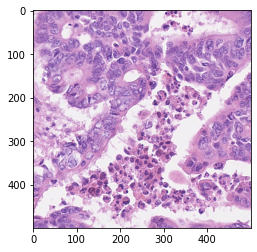

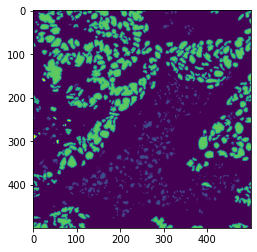

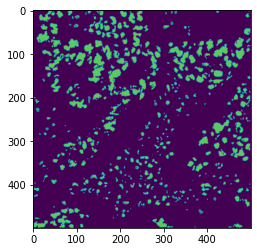

In [15]:
import matplotlib.pyplot as plt
pic=10
label=np.zeros((500,500))
for i in range(len(Y_test[pic])):
  for j in range(len(Y_test[pic][i])):
    label[i,j]=np.argmax(Y_test[pic][i][j])
predicted=np.zeros((500,500))
for i in range(len(predict_test[pic])):
  for j in range(len(predict_test[pic][i])):
    predicted[i,j]=np.argmax(predict_test[pic][i][j])
plt.imshow((X_test[pic]).astype(np.uint8))
plt.show()
plt.imshow(label)
plt.show()
plt.imshow(predicted)
plt.show()

In [ ]:
predict_train=full_model.predict(X_train[:10])

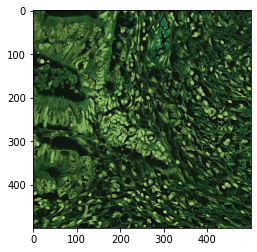

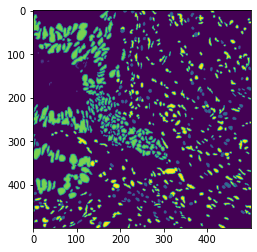

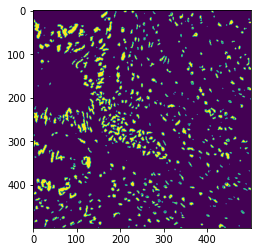

In [ ]:
pic=0
label=np.zeros((500,500))
for i in range(len(Y_train[pic])):
  for j in range(len(Y_train[pic][i])):
    label[i,j]=np.argmax(Y_train[pic][i][j])
predicted=np.zeros((500,500))
for i in range(len(predict_train[pic])):
  for j in range(len(predict_train[pic][i])):
    predicted[i,j]=np.argmax(predict_train[pic][i][j])
plt.imshow((X_train[pic]).astype(np.uint8))
plt.show()
plt.imshow(label)
plt.show()
plt.imshow(predicted)
plt.show()

Confiusion Matrix and other metrics

In [ ]:
y_test=np.zeros((500,500))
for k in range(len(Y_test)):
  for i in range(len(Y_test[k])):
    for j in range(len(Y_test[k][i])):
      y_test[i,j]=np.argmax(Y_test[k][i][j])
y_pred=np.zeros((500,500))
for k in range(len(predict_test)):
  for i in range(len(predict_test[k])):
    for j in range(len(predict_test[k][i])):
      y_pred[i,j]=np.argmax(predict_test[k][i][j])

In [ ]:
len(Y_test)

14

In [ ]:
CM=np.zeros((5,5))
for i in range(5):
  for j in range(5):
    CM[i,j]=np.sum((y_pred==j)*(y_test==i))
    
np.set_printoptions(suppress=True)
CM

array([[181000.,      2.,    399.,      0.,  10076.,      0.,      0.,
             0.],
       [  3328.,      0.,    130.,      0.,   1638.,      0.,      0.,
             0.],
       [  3462.,      0.,    121.,      0.,   2316.,      0.,      0.,
             0.],
       [  4059.,      0.,    262.,      0.,   7279.,      0.,      0.,
             0.],
       [  9922.,      0.,    997.,      0.,  23186.,      0.,      0.,
             0.],
       [   277.,      0.,    204.,      0.,   1342.,      0.,      0.,
             0.],
       [     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.],
       [     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.]])

In [ ]:
import pandas as pd
pd.DataFrame(CM)

,0,1,2,3,4,5,6,7
0,181000.0,2.0,399.0,0.0,10076.0,0.0,0.0,0.0
1,3328.0,0.0,130.0,0.0,1638.0,0.0,0.0,0.0
2,3462.0,0.0,121.0,0.0,2316.0,0.0,0.0,0.0
3,4059.0,0.0,262.0,0.0,7279.0,0.0,0.0,0.0
4,9922.0,0.0,997.0,0.0,23186.0,0.0,0.0,0.0
5,277.0,0.0,204.0,0.0,1342.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for i in range(5):
    true_positive = np.sum((y_pred == i) * (y_test == i))
    true_negative = np.sum((y_pred != i) * (y_test != i))
    false_positive = np.sum((y_pred == i) * (y_test != i))
    false_negative = np.sum((y_pred != i) * (y_test == i))

    acc = (true_positive + true_negative) / (X_test.shape[0]) * 100
    precision = true_positive / (true_positive + false_positive) * 100
    recall = true_positive / (true_positive + false_negative) * 100
    print('on label {}, acc={:0.2f}, precision={:0.2f}, recall={:0.2f}'.format(i, acc, precision, recall))

on label 0, acc=1560535.71, precision=89.58, recall=94.53
on label 1, acc=1749300.00, precision=0.00, recall=0.00
on label 2, acc=1730214.29, precision=5.73, recall=2.05
on label 3, acc=1702857.14, precision=nan, recall=0.00
on label 4, acc=1545928.57, precision=50.58, recall=67.98
on label 5, acc=1772692.86, precision=nan, recall=0.00
on label 6, acc=1785714.29, precision=nan, recall=nan
on label 7, acc=1785714.29, precision=nan, recall=nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


#With Unet Model From segmentation_models

In [ ]:
!pip install segmentation_models

     |████████████████████████████████| 50 kB 6.2 MB/s 


In [ ]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,Input,GlobalMaxPooling2D
from tensorflow.keras.models import load_model,Model
from segmentation_models import Unet

unet_model = Unet(backbone_name='resnet34', encoder_weights='imagenet')
inp = Input(shape=(224, 224, 3))
x = unet_model(inp)
x = Conv2D(8, (3,3), padding='same', activation='softmax')(x)
full_model = Model(inputs=[inp], outputs=[x])

In [ ]:
full_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model_4 (Functional)         (None, None, None, 1)     24456154  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 8)       80        
Total params: 24,456,234
Trainable params: 24,438,884
Non-trainable params: 17,350
_________________________________________________________________


In [ ]:
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
unet_model.trainable=False
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[iou_score])
full_model.fit(
    x=X_train,
    y=Y_train,
    batch_size=10,
    epochs=10)

Epoch 1/10
3/3 [==============================] - 8s 631ms/step - loss: 2.3391 - iou_score: 0.0288
Epoch 2/10
3/3 [==============================] - 0s 118ms/step - loss: 2.3155 - iou_score: 0.0296
Epoch 3/10
3/3 [==============================] - 0s 118ms/step - loss: 2.2922 - iou_score: 0.0301
Epoch 4/10
3/3 [==============================] - 0s 123ms/step - loss: 2.2690 - iou_score: 0.0309
Epoch 5/10
3/3 [==============================] - 0s 120ms/step - loss: 2.2455 - iou_score: 0.0312
Epoch 6/10
3/3 [==============================] - 0s 121ms/step - loss: 2.2220 - iou_score: 0.0309
Epoch 7/10
3/3 [==============================] - 0s 122ms/step - loss: 2.1993 - iou_score: 0.0317
Epoch 8/10
3/3 [==============================] - 0s 123ms/step - loss: 2.1764 - iou_score: 0.0321
Epoch 9/10
3/3 [==============================] - 0s 116ms/step - loss: 2.1533 - iou_score: 0.0321
Epoch 10/10
3/3 [==============================] - 0s 114ms/step - loss: 2.1309 - iou_score: 0.0328


In [ ]:
unet_model.trainable=True
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[iou_score])

full_model.fit(
    x=X_train,
    y=Y_train,
    batch_size=10,
    epochs=40)

Epoch 1/40
3/3 [==============================] - 7s 330ms/step - loss: 1.8523 - iou_score: 0.0398
Epoch 2/40
3/3 [==============================] - 1s 324ms/step - loss: 1.8181 - iou_score: 0.0407
Epoch 3/40
3/3 [==============================] - 1s 329ms/step - loss: 1.7828 - iou_score: 0.0410
Epoch 4/40
3/3 [==============================] - 1s 325ms/step - loss: 1.7502 - iou_score: 0.0425
Epoch 5/40
3/3 [==============================] - 1s 326ms/step - loss: 1.7200 - iou_score: 0.0431
Epoch 6/40
3/3 [==============================] - 1s 327ms/step - loss: 1.6802 - iou_score: 0.0440
Epoch 7/40
3/3 [==============================] - 1s 327ms/step - loss: 1.6450 - iou_score: 0.0450
Epoch 8/40
3/3 [==============================] - 1s 321ms/step - loss: 1.6072 - iou_score: 0.0470
Epoch 9/40
3/3 [==============================] - 1s 324ms/step - loss: 1.5720 - iou_score: 0.0484
Epoch 10/40
3/3 [==============================] - 1s 322ms/step - loss: 1.5348 - iou_score: 0.0498
Epoch 11/

In [ ]:
full_model.evaluate(X_test,Y_test)

1/1 [==============================] - 11s 11s/step - loss: 3.4239 - iou_score: 0.7893


[3.4239370822906494, 0.7892863750457764]

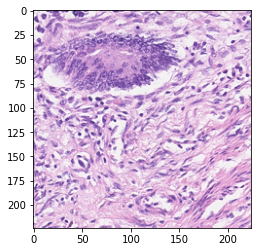

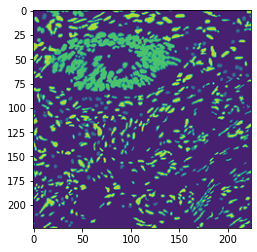

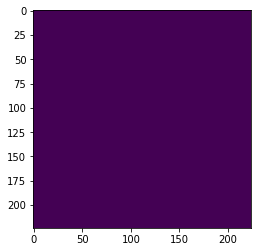

In [ ]:
plt.imshow(X_test[0].astype(np.uint8))
plt.show()
plt.imshow(Y_test[0])
plt.show()
plt.imshow(full_model.predict(X_test[0].reshape(-1,224,224,3)).reshape(224,224))
plt.show()

In [ ]:
X_test[0].shape

(224, 224, 3)

In [ ]:
a=full_model.predict(X_train[0].reshape(-1,224,224,3))


In [ ]:
a.shape


(1, 224, 224, 1)

#With Unet Model From keras_unet_collection

In [ ]:
!pip install keras-unet-collection

     |████████████████████████████████| 67 kB 3.1 MB/s 


In [ ]:
from keras_unet_collection import models

model = models.unet_2d((256,256,3),filter_num=[64, 128, 256, 512, 1024],backbone='VGG16',n_labels=8,weights='imagenet')


58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
inp = Input(shape=(256, 256, 3))
x = model(inp)
x = Conv2D(8, (3,3), padding='same', activation='softmax')(x)
full_model = Model(inputs=[inp], outputs=[x])

In [ ]:
model.trainable=False
full_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
full_model.fit(X_train,Y_train,epochs=10,batch_size=10)

Epoch 1/10
3/3 [==============================] - 2s 479ms/step - loss: 1.2263 - acc: 0.8125
Epoch 2/10
3/3 [==============================] - 1s 476ms/step - loss: 1.2064 - acc: 0.8127
Epoch 3/10
3/3 [==============================] - 1s 473ms/step - loss: 1.1868 - acc: 0.8128
Epoch 4/10
3/3 [==============================] - 1s 473ms/step - loss: 1.1683 - acc: 0.8129
Epoch 5/10
3/3 [==============================] - 1s 468ms/step - loss: 1.1508 - acc: 0.8129
Epoch 6/10
3/3 [==============================] - 1s 471ms/step - loss: 1.1342 - acc: 0.8130
Epoch 7/10
3/3 [==============================] - 1s 480ms/step - loss: 1.1175 - acc: 0.8130
Epoch 8/10
3/3 [==============================] - 1s 473ms/step - loss: 1.1024 - acc: 0.8130
Epoch 9/10
3/3 [==============================] - 1s 476ms/step - loss: 1.0873 - acc: 0.8130
Epoch 10/10
3/3 [==============================] - 1s 473ms/step - loss: 1.0735 - acc: 0.8130


In [ ]:
model.trainable=True
full_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
full_model.fit(X_train,Y_train,epochs=20,batch_size=3)

Epoch 1/20
9/9 [==============================] - 15s 758ms/step - loss: 0.9276 - acc: 0.8130
Epoch 2/20
9/9 [==============================] - 7s 755ms/step - loss: 0.8945 - acc: 0.8130
Epoch 3/20
9/9 [==============================] - 7s 752ms/step - loss: 0.8772 - acc: 0.8130
Epoch 4/20
9/9 [==============================] - 7s 749ms/step - loss: 0.8647 - acc: 0.8130
Epoch 5/20
9/9 [==============================] - 7s 751ms/step - loss: 0.8544 - acc: 0.8130
Epoch 6/20
9/9 [==============================] - 7s 749ms/step - loss: 0.8471 - acc: 0.8130
Epoch 7/20
9/9 [==============================] - 7s 751ms/step - loss: 0.8408 - acc: 0.8130
Epoch 8/20
9/9 [==============================] - 7s 752ms/step - loss: 0.8360 - acc: 0.8130
Epoch 9/20
9/9 [==============================] - 7s 747ms/step - loss: 0.8318 - acc: 0.8130
Epoch 10/20
9/9 [==============================] - 7s 750ms/step - loss: 0.8284 - acc: 0.8130
Epoch 11/20
9/9 [==============================] - 7s 749ms/step - l

In [ ]:
full_model.evaluate(X_test,Y_test)

1/1 [==============================] - 15s 15s/step - loss: 0.9213 - acc: 0.7781


[0.9213482737541199, 0.7781491875648499]

In [ ]:
predict_test=full_model.predict(X_test)

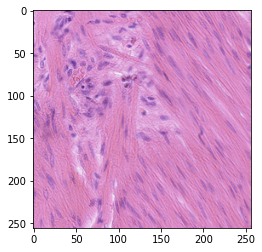

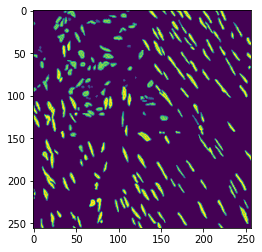

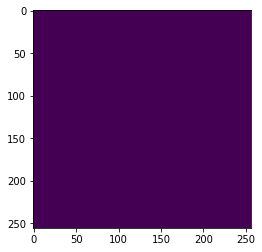

In [ ]:
import matplotlib.pyplot as plt
pic=1
label=np.zeros((256,256))
for i in range(len(Y_test[pic])):
  for j in range(len(Y_test[pic][i])):
    label[i,j]=np.argmax(Y_test[pic][i][j])
predicted=np.zeros((256,256))
for i in range(len(predict_test[pic])):
  for j in range(len(predict_test[pic][i])):
    predicted[i,j]=np.argmax(predict_test[pic][i][j])
plt.imshow((X_test[pic]).astype(np.uint8))
plt.show()
plt.imshow(label)
plt.show()
plt.imshow(predicted)
plt.show()

#With Unet Model From https://github.com/zhixuhao/unet

In [ ]:
unet_model=load_model('/content/drive/MyDrive/unet_membrane.hdf5')

In [ ]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_1_conv (Conv2D)           (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_1_bn (BatchNormalization) (None, 128, 128, 32) 128         conv1_1_conv[0][0]               
__________________________________________________________________________________________________
conv1_1_activation (Activation) (None, 128, 128, 32) 0           conv1_1_bn[0][0]                 
____________________________________________________________________________________________

In [ ]:
inp = Input(shape=(128, 128, 3))
x = unet_model(inp)
x = Conv2D(8, (3,3), padding='same', activation='softmax')(x)
full_model = Model(inputs=[inp], outputs=[x])

In [ ]:
unet_model.trainable=False
full_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
full_model.fit(X_train,Y_train,epochs=5,batch_size=3)

Epoch 1/5
9/9 [==============================] - 0s 35ms/step - loss: 1.1809 - acc: 0.7901
Epoch 2/5
9/9 [==============================] - 0s 31ms/step - loss: 1.1335 - acc: 0.7902
Epoch 3/5
9/9 [==============================] - 0s 28ms/step - loss: 1.0943 - acc: 0.7902
Epoch 4/5
9/9 [==============================] - 0s 26ms/step - loss: 1.0621 - acc: 0.7902
Epoch 5/5
9/9 [==============================] - 0s 28ms/step - loss: 1.0317 - acc: 0.7902


In [ ]:
unet_model.trainable=True
full_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
full_model.fit(X_train,Y_train,epochs=20,batch_size=3)

Epoch 1/20
9/9 [==============================] - 3s 69ms/step - loss: 1.0980 - acc: 0.7902
Epoch 2/20
9/9 [==============================] - 1s 69ms/step - loss: 1.0221 - acc: 0.7902
Epoch 3/20
9/9 [==============================] - 1s 69ms/step - loss: 0.9634 - acc: 0.7902
Epoch 4/20
9/9 [==============================] - 1s 70ms/step - loss: 0.9240 - acc: 0.7902
Epoch 5/20
9/9 [==============================] - 1s 68ms/step - loss: 0.8893 - acc: 0.7902
Epoch 6/20
9/9 [==============================] - 1s 69ms/step - loss: 0.8531 - acc: 0.7902
Epoch 7/20
9/9 [==============================] - 1s 71ms/step - loss: 0.8456 - acc: 0.7902
Epoch 8/20
9/9 [==============================] - 1s 71ms/step - loss: 0.8191 - acc: 0.7902
Epoch 9/20
9/9 [==============================] - 1s 68ms/step - loss: 0.8032 - acc: 0.7902
Epoch 10/20
9/9 [==============================] - 1s 68ms/step - loss: 0.7795 - acc: 0.7902
Epoch 11/20
9/9 [==============================] - 1s 69ms/step - loss: 0.7646 

In [ ]:
full_model.evaluate(X_test,Y_test)

1/1 [==============================] - 2s 2s/step - loss: 1.0898 - acc: 0.7523


[1.089788556098938, 0.7522670030593872]

In [ ]:
predict_test=full_model.predict(X_test)

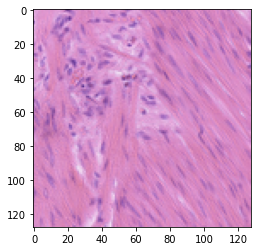

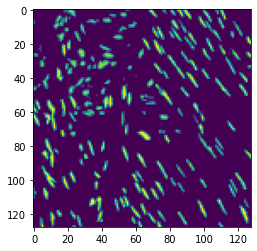

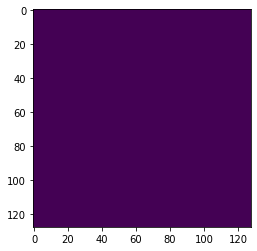

In [ ]:
import matplotlib.pyplot as plt
pic=1
label=np.zeros((128,128))
for i in range(len(Y_test[pic])):
  for j in range(len(Y_test[pic][i])):
    label[i,j]=np.argmax(Y_test[pic][i][j])
predicted=np.zeros((128,128))
for i in range(len(predict_test[pic])):
  for j in range(len(predict_test[pic][i])):
    predicted[i,j]=np.argmax(predict_test[pic][i][j])
plt.imshow((X_test[pic]).astype(np.uint8))
plt.show()
plt.imshow(label)
plt.show()
plt.imshow(predicted)
plt.show()